# Biodata

**Fida Mardliyah // fidamardliyah11@gmail.com**

Sumber Data : https://www.kaggle.com/ishantjuyal/language-detection-dataset

# Import Data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv('ireland-news-headlines.csv')

In [ ]:
data.head()

,publish_date,headline_category,headline_text
0,19960102,news,UUP sees possibility of voting Major out
1,19960102,news,Pubs targeted as curbs on smoking are extended
2,19960102,news,Papers reveal secret links with O'Neill cabinet
3,19960102,news,Domestic chaos as Italy takes EU presidency
4,19960102,news,Learning about the star to which we owe life


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484340 entries, 0 to 1484339
Data columns (total 3 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   publish_date       1484340 non-null  int64 
 1   headline_category  1484340 non-null  object
 2   headline_text      1484340 non-null  object
dtypes: int64(1), object(2)
memory usage: 34.0+ MB


In [ ]:
data.shape

(1484340, 3)

# Preprocessing

## Missing Value

In [ ]:
data.isnull().values.any()

False

In [ ]:
data = data.drop(columns='publish_date')

In [ ]:
data

,headline_category,headline_text
0,news,UUP sees possibility of voting Major out
1,news,Pubs targeted as curbs on smoking are extended
2,news,Papers reveal secret links with O'Neill cabinet
3,news,Domestic chaos as Italy takes EU presidency
4,news,Learning about the star to which we owe life
...,...,...
1484335,news.ireland,Traveller fails in race claim against Michael ...
1484336,lifestyle.abroad,Happy New Year from Irish Times Abroad!
1484337,news.law,Lisa Smith released on bail and moved to undis...
1484338,news.ireland,Person killed after being hit by train in Belfast


## Label Desc

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

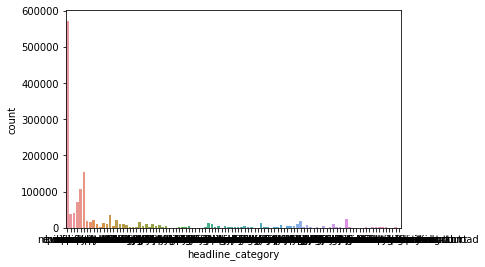

In [ ]:
sns.countplot(x='headline_category', data=data)

## One-Hot Encodding

In [ ]:
category =pd.get_dummies(data.headline_category)
datanew = pd.concat([data, category], axis=1)
datanew = datanew.drop(columns='headline_category')
datanew

,headline_text,business,business.agribusiness-and-food,business.commercial-property,business.companies,business.construction,business.economy,business.economy.employment,business.economy.europe,business.economy.ireland,business.economy.public-finances,business.economy.world,business.energy-and-resources,business.financial-services,business.health-pharma,business.innovation,business.manufacturing,business.markets,business.markets.bonds,business.markets.equities,business.media-and-marketing,business.personal-finance,business.retail-and-services,business.technology,business.transport-and-tourism,business.work,culture,culture.books,culture.design,culture.film,culture.game-reviews,culture.heritage,culture.media,culture.music,culture.music.album-reviews,culture.stage,culture.treibh,culture.tv-radio-web,lifestyle,lifestyle.abroad,...,lifestyle.travel.long-haul,news,news.consumer,news.education,news.environment,news.health,news.ireland,news.law,news.law.courts,news.law.courts.circuit-court,news.law.courts.coroners-court,news.law.courts.criminal-court,news.law.courts.district-court,news.law.courts.high-court,news.law.courts.supreme-court,news.offbeat,news.politics,news.politics.oireachtas,news.science,news.social,news.social.beliefs,news.technology,news.world,news.world.africa,news.world.asia-pacific,news.world.europe,news.world.middle-east,news.world.uk,news.world.us,opinion,opinion.editorial,opinion.letters,removed,sport,sport.gaelic,sport.golf,sport.others,sport.racing,sport.rugby,sport.soccer
0,UUP sees possibility of voting Major out,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Pubs targeted as curbs on smoking are extended,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Papers reveal secret links with O'Neill cabinet,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Domestic chaos as Italy takes EU presidency,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Learning about the star to which we owe life,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484335,Traveller fails in race claim against Michael ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1484336,Happy New Year from Irish Times Abroad!,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1484337,Lisa Smith released on bail and moved to undis...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1484338,Person killed after being hit by train in Belfast,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
text = datanew['Text_Snippet'].values
label = datanew[['Books', 'Film', 'Music']].values

# Split Data

In [ ]:
from sklearn.model_selection import train_test_split
text_train, text_val, label_train, label_val = train_test_split(text, label, test_size=0.2)

# Tokenizer & Sequences

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(num_words=8000, oov_token='<OOV>')
tokenizer.fit_on_texts(text_train)
tokenizer.fit_on_texts(text_val)

In [ ]:
sequences_train = tokenizer.texts_to_sequences(text_train)
sequences_val = tokenizer.texts_to_sequences(text_val)

padded_train = pad_sequences(sequences_train) 
padded_val = pad_sequences(sequences_val)

# Modelling

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.layers import Activation
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Sequential

In [ ]:
model = Sequential([
    Embedding(input_dim=8000, output_dim=128),
    LSTM(128),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         1024000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 195       
Total params: 1,090,179
Trainable params: 1,090,179
Non-trainable params: 0
____________________________________________

## Compile Optimizer

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

## Callbacks

In [ ]:
class mycb(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if(logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.90):
      print('\nFor Epoch', epoch, '\nAccuracy has reach = %2.2f%%' %(logs['accuracy']*100), 'stop training.'),
      self.model.stop_training = True

# Fit Training

In [ ]:
fitmodel = model.fit(padded_train, label_train,
                     steps_per_epoch = 25, epochs = 100, 
                     validation_data = (padded_val, label_val), validation_steps=5,
                     verbose=2, callbacks = [mycb()]
                     )

Epoch 1/100
25/25 - 9s - loss: 1.0934 - accuracy: 0.3860 - val_loss: 1.0483 - val_accuracy: 0.4536
Epoch 2/100
25/25 - 5s - loss: 0.7631 - accuracy: 0.6878 - val_loss: 0.6550 - val_accuracy: 0.7468
Epoch 3/100
25/25 - 5s - loss: 0.2886 - accuracy: 0.9072 - val_loss: 0.5922 - val_accuracy: 0.7774
Epoch 4/100
25/25 - 5s - loss: 0.1000 - accuracy: 0.9687 - val_loss: 0.6836 - val_accuracy: 0.7755
Epoch 5/100
25/25 - 5s - loss: 0.0353 - accuracy: 0.9914 - val_loss: 1.0485 - val_accuracy: 0.7690
Epoch 6/100
25/25 - 5s - loss: 0.0164 - accuracy: 0.9951 - val_loss: 0.9622 - val_accuracy: 0.7690
Epoch 7/100
25/25 - 5s - loss: 0.0076 - accuracy: 0.9988 - val_loss: 1.1614 - val_accuracy: 0.7644
Epoch 8/100
25/25 - 5s - loss: 0.0088 - accuracy: 0.9984 - val_loss: 1.1804 - val_accuracy: 0.7635
Epoch 9/100
25/25 - 5s - loss: 0.0048 - accuracy: 0.9991 - val_loss: 1.2129 - val_accuracy: 0.7699
Epoch 10/100
25/25 - 5s - loss: 0.0020 - accuracy: 0.9995 - val_loss: 1.2854 - val_accuracy: 0.7727
Epoch 11/

# Perbandingan Plot

## Akurasi

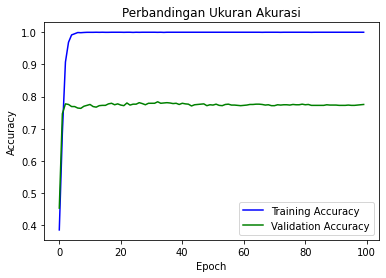

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(fitmodel.history['accuracy']))

plt.plot(epochs, fitmodel.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(fitmodel.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Perbandingan Ukuran Akurasi')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()

## Loss

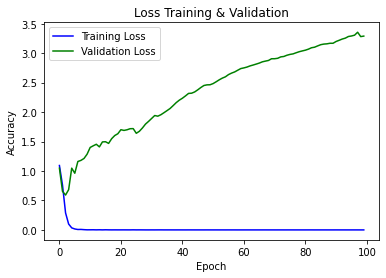

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, fitmodel.history['loss'], label='Training Loss', color='blue')
plt.plot(epochs, fitmodel.history['val_loss'], label='Validation Loss', color = 'green')
plt.title('Loss Training & Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.figure()

plt.show()